# 0. Imports & set-up

In [4]:
from google.cloud import bigquery
from google.oauth2 import service_account

!pip install sequitur
import torch
from sequitur.models import LINEAR_AE
from sequitur import quick_train

In [1]:
# Mount drive - needed for GBQ creds
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root_path = '/content/drive/MyDrive/GitHub'

In [5]:
credentials = service_account.Credentials.from_service_account_file(
    f'{root_path}/grav-waves/grav-waves-358320-34ebfeae2689.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

In [ ]:
# https://stackoverflow.com/questions/65876808/feeding-classifier-data-from-lstm-autoencoder
# https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

# 1. Train the autoencoder

In [154]:
# My attempt
train_seqs = [torch.tensor([0.9000, 0.2000, 0.8000, 0.1500, 0.9000, 0.2000, 0.8500, 0.1200, 0.9000]),
 torch.tensor([0.8000, 0.2000, 0.8500, 0.2500, 0.8000, 0.1500, 0.8000, 0.1000, 0.9000])] # 2 sequences of length 9

# Train
encoder, decoder, encodings, losses = quick_train(LINEAR_AE, train_seqs, encoding_dim = 6, denoise = True, verbose = False) # Bottleneck = 6

# Test
test_seqs = [torch.tensor([0.90, 0.2000, 0.8500, 0.15, 0.8000, 0.1500, 0.90, 0.1000, 0.9000]),
             torch.tensor([0.90, 0.15, 0.77, 0.12, 0.8000, 0.1200, 0.80, 0.1000, 0.85])]

# z_s = []
# x_primes = []

for i in test_seqs:
  z = encoder(i) # Pass through new observation
  x_prime = decoder(z)

  print(f'z is {z}')
  print(f'x prime is {x_prime}')

z is tensor([-0.6935, -0.3869,  0.5957, -0.4306,  0.5435,  0.5874],
       grad_fn=<TanhBackward0>)
x prime is tensor([0.5377, 0.2606, 0.6169, 0.1664, 0.3436, 0.2749, 0.7379, 0.1076, 0.7026],
       grad_fn=<AddBackward0>)
z is tensor([-0.6560, -0.3568,  0.5787, -0.4383,  0.5461,  0.5818],
       grad_fn=<TanhBackward0>)
x prime is tensor([0.5188, 0.2469, 0.5868, 0.1656, 0.3313, 0.2700, 0.7385, 0.1050, 0.7075],
       grad_fn=<AddBackward0>)


/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [158]:
x_prime_np = x_prime.detach().cpu().numpy()
z_np = z.detach().cpu().numpy()

In [159]:
x_orig = np.array([0.90, 0.15, 0.77, 0.12, 0.8000, 0.1200, 0.80, 0.1000, 0.85])

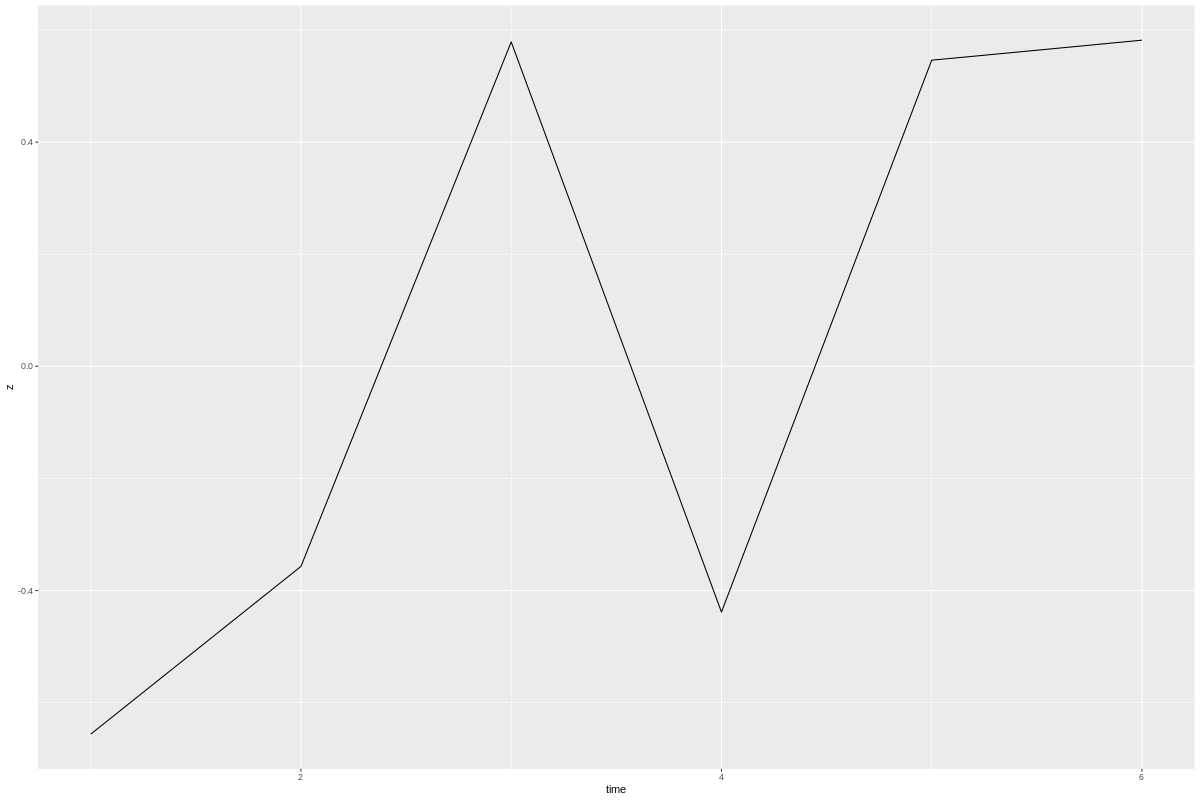

In [163]:
%%R -i z_np -h 800 -w 1200

data.frame(z = z_np,
           time = seq(1, length(z_np))) %>%
ggplot(aes(time, z)) +
geom_line()

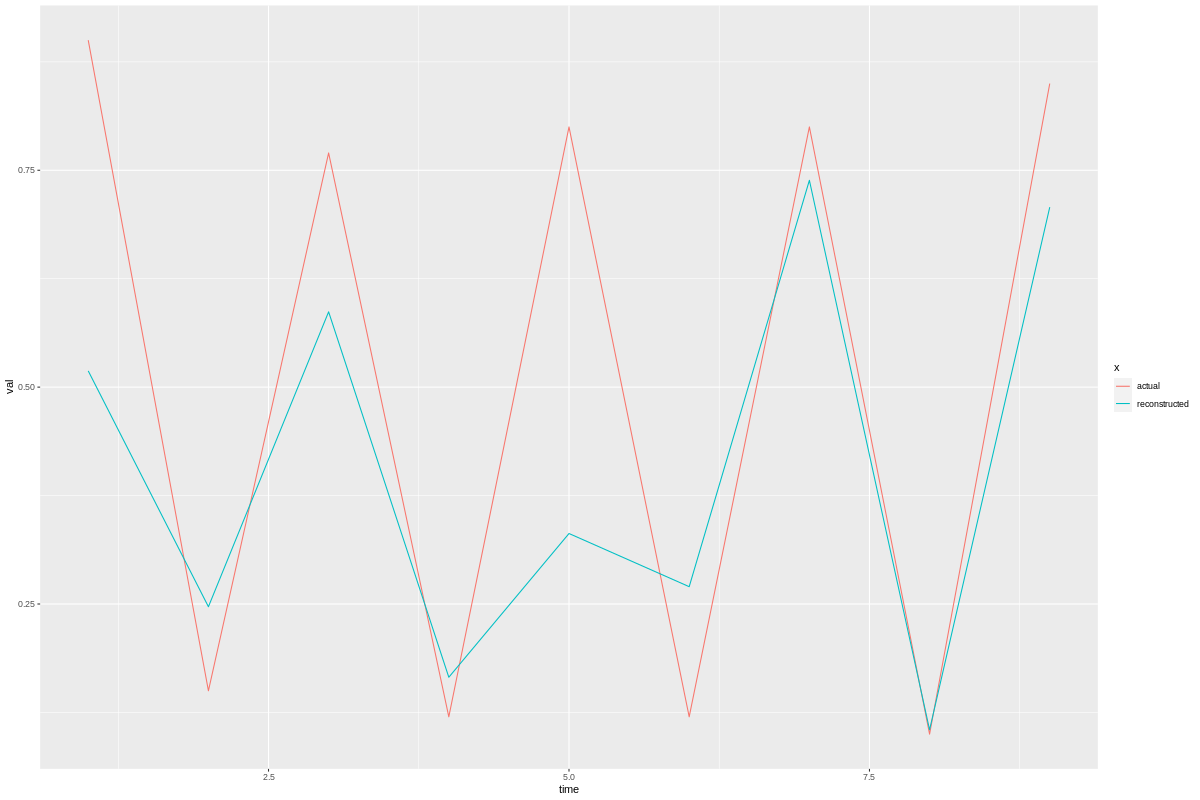

In [164]:
%%R -i x_prime_np -i x_orig -h 800 -w 1200

# Plot reconstructued vs. actual
data.frame(actual = x_orig,
           reconstructed = x_prime_np,
           time = seq(1, length(x_orig))) %>%
gather(actual, reconstructed, key = "x", value = "val") %>%
ggplot(aes(time, val, color = x)) +
geom_line()

# 2. Evaluate the reconstruction loss